In [66]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json

In [93]:
# Tform for imagenet data
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class MyImageFolder(datasets.ImageFolder):
    """Override ImageFolder to also return the filename of the sample, in order to visualize"""
    def __getitem__(self, index):
        return super(MyImageFolder, self).__getitem__(index), self.imgs[index][0]

dataset = MyImageFolder(root='C:\\School\\Fall2020\\applied-deep-learning\\data\\', transform=transform)
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [120]:
# Test to make sure it is working
for (img, _), filename in dataloader:
    print(filename[0])

C:\School\Fall2020\applied-deep-learning\data\dog\broncos.jpg
C:\School\Fall2020\applied-deep-learning\data\dog\dog.jpg
C:\School\Fall2020\applied-deep-learning\data\dog\komodo.jpg
C:\School\Fall2020\applied-deep-learning\data\dog\piano.jpg
C:\School\Fall2020\applied-deep-learning\data\dog\shark.jpg


I downloaded the imagenet labels from [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), so that I could convert the index to a human-readable format

In [121]:
imagenet_labels = json.load(open('../../../data/imagenet_labels.json'))

Take a look at the architecture to determine where the last conv layer is

In [12]:
vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\sorou/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In order to follow CAM, we need to grab the gradients from an intermediate stage in the model. However, PyTorch does not cache all gradients by default. So, we must implement a custom VGG that stores the gradients we care about

In [16]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = vgg19(pretrained=True)
        
        # Split network into the features part (up to the last conv) and the classifier part
        self.features_conv = self.vgg.features[:36]
        self.classifier = self.vgg.classifier
        
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    
        # Hold onto the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        # Simply cache the gradient
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # Register a 'hook', i.e. a callback to happen at this point
        # See: https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook
        h = x.register_hook(self.activations_hook)
        
        # Rest of the network
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # Return the activations for a given input
    def get_activations(self, x):
        return self.features_conv(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


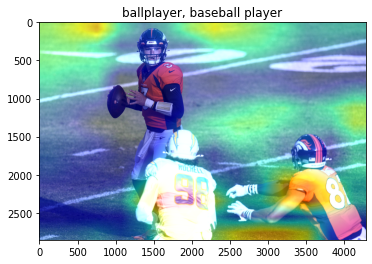

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


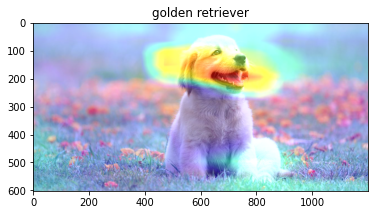

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


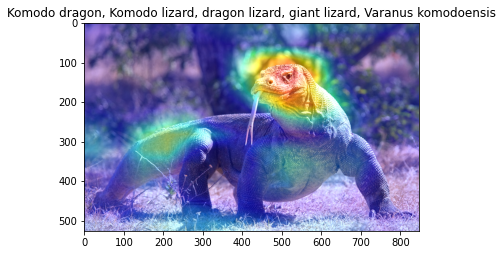

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


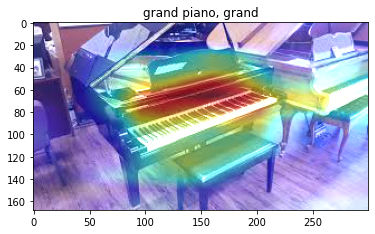

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


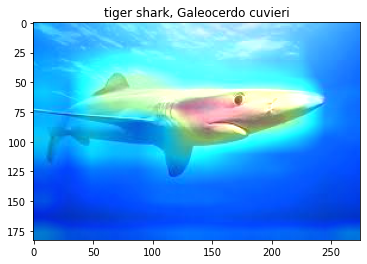

In [126]:
vgg = VGG()
vgg.eval()

for (img, _), filename in dataloader:
    # Forward pass
    pred = vgg(img)
    pred_class = int(pred.argmax(dim=1))

    # Get gradients, grab the cached activation gradients
    pred[:, pred_class].backward()
    gradients = vgg.gradients

    # Mean across channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Run the partial forward pass, i.e. just up to the last conv layer
    activations = vgg.get_activations(img).detach()

    # Weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # Take mean of all
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Relu
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # Normalize
    heatmap /= torch.max(heatmap)
    
    # Read in original image
    img = cv2.imread(filename[0])
    
    # Interpolate the heatmap from the size of the feature map (14x14) to the image size
    heatmap_cv = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    
    # Convert to an actual heatmap
    heatmap_cv = np.uint8(255 * heatmap_cv)
    heatmap_cv = cv2.applyColorMap(heatmap_cv, cv2.COLORMAP_JET)
    
    # Combine
    superimposed_img = heatmap_cv*0.5 + img
    
    # Display
    plt.imshow(cv2.cvtColor(superimposed_img.astype('float32'), cv2.COLOR_BGR2RGB).astype(int))
    plt.title(imagenet_labels[str(pred_class)])
    plt.show()

These results are really interesting, and the changes were super easy to make. What stands out to me is the image of the Broncos, since I was hoping for the class 'Football Helmet', but the class selected was 'Baseball Player'. What is great about CAM is that I could see *WHY* the model chose this class. It was focusing on the grass around the players, showing that there may be a data inconsistancy in that class, and the network generalized to grass instead of the actual subject matter

If I pass in the football helmet class, I wonder if the model will activate near the helmets...

In [131]:
for (img, _), filename in dataloader:
    if 'broncos' in filename[0]:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


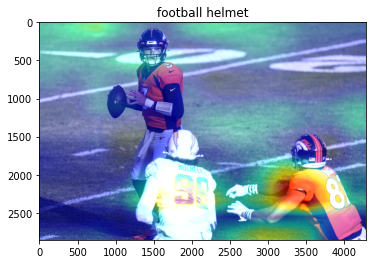

In [132]:
# Forward pass
pred = vgg(img)
# pred_class = int(pred.argmax(dim=1))
pred_class = 560

# Get gradients, grab the cached activation gradients
pred[:, pred_class].backward()
gradients = vgg.gradients

# Mean across channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# Run the partial forward pass, i.e. just up to the last conv layer
activations = vgg.get_activations(img).detach()

# Weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# Take mean of all
heatmap = torch.mean(activations, dim=1).squeeze()

# Relu
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# Normalize
heatmap /= torch.max(heatmap)

# Read in original image
img = cv2.imread(filename[0])

# Interpolate the heatmap from the size of the feature map (14x14) to the image size
heatmap_cv = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))

# Convert to an actual heatmap
heatmap_cv = np.uint8(255 * heatmap_cv)
heatmap_cv = cv2.applyColorMap(heatmap_cv, cv2.COLORMAP_JET)

# Combine
superimposed_img = heatmap_cv*0.5 + img

# Display
plt.imshow(cv2.cvtColor(superimposed_img.astype('float32'), cv2.COLOR_BGR2RGB).astype(int))
plt.title(imagenet_labels[str(pred_class)])
plt.show()